In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# Úvod
V tomto souboru je přepočítána asijská opce podle souboru `vypocty_diplomova_prace_asian_gbm`, ale od pozdějšího data (poslední záznam je 13/5/2020), kdy už se denní ceny nachází v průměrovacím období.

# Příprava dat

In [2]:
raw_data = pd.read_csv("datasets/CLN20.NYM_newer.csv",delimiter=";")
data1 = raw_data.set_index(raw_data.columns[0])
data1
contract_raw = data1.iloc[:,3]
contract_raw = contract_raw["2019-05-06":]#"2020-02-01"]
contract_raw.index = pd.to_datetime(contract_raw.index)
contract_raw = contract_raw.asfreq(BDay())
contract_raw = contract_raw.fillna(method='ffill').dropna()
contract_raw.tail()

pct_ch = contract_raw.pct_change()
contract = pd.DataFrame({"contract":contract_raw,"%change":pct_ch}, index=contract_raw.index).dropna()
contract["logreturn"] = np.log(contract_raw/contract_raw.shift(1))
contract["delta"] = contract_raw - contract_raw.shift(1)
contract["shifted_contract"] = contract_raw.shift()

contract.tail()

,contract,%change,logreturn,delta,shifted_contract
Date,,,,,
2020-05-07,24.920000,-0.014241,-0.014343,-0.360001,25.280001
2020-05-08,26.040001,0.044944,0.043963,1.120001,24.920000
2020-05-11,25.430000,-0.023426,-0.023704,-0.610001,26.040001
2020-05-12,25.719999,0.011404,0.011339,0.289999,25.430000
2020-05-13,26.410000,0.026827,0.026474,0.690001,25.719999


### Grafy k červencovému kontraktu

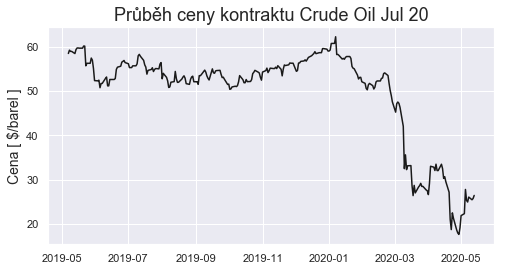

In [3]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(contract.iloc[:,0], c="k")
ax.set_title("Průběh ceny kontraktu Crude Oil Jul 20", fontsize=18)
ax.set_ylabel("Cena [ $/barel ]",fontsize=14)
fig.savefig('CLN20.NYM_prices2.pdf', format='pdf', bbox_inches='tight')

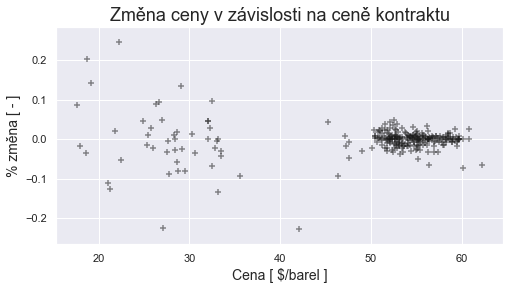

In [4]:

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Změna ceny v závislosti na ceně kontraktu", fontsize=18)
ax.scatter(contract["shifted_contract"], contract["%change"], c="k", marker="+", alpha=0.5)
ax.set_ylabel("% změna [ - ]",fontsize=14)
ax.set_xlabel("Cena [ $/barel ]",fontsize=14)
fig.savefig('CLN20.NYM_scatter2.pdf', format='pdf', bbox_inches='tight')

# Asijská opce simulační výpočet

Rozdělit Jul 20 dataset na 2 podle ceny  
Hodnotu $45 jsem určil podle osy y v předchozím grafu, změna nepřesahuje nad touto cenou hodnoty +-0.05, pod touto cenou je rozptyl dat výrazně větší.

In [5]:
contract_low = contract[contract["shifted_contract"]<45]
contract_high = contract[contract["shifted_contract"]>=45]

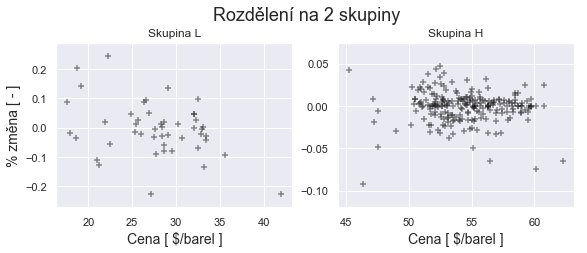

In [6]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
fig.tight_layout()
fig.suptitle('Rozdělení na 2 skupiny', fontsize=18, y=1.08)
ax1.scatter(contract_low["shifted_contract"], contract_low["%change"],c="k", marker="+", alpha=0.5)
ax1.set_title("Skupina L")
ax1.set_xlabel("Cena [ $/barel ]",fontsize=14)
ax1.set_ylabel("% změna [ - ]",fontsize=14)
ax2.scatter(contract_high["shifted_contract"], contract_high["%change"],c="k", marker="+", alpha=0.5)
ax2.set_xlabel("Cena [ $/barel ]",fontsize=14)
ax2.set_title("Skupina H")
fig.savefig('CLN20.NYM_scatter_separated2.pdf', format='pdf', bbox_inches='tight')

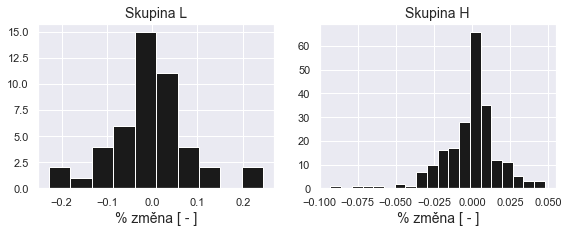

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
fig.tight_layout()
ax1.hist(contract_low["%change"], color="k", bins=10)
ax1.set_title("Skupina L", fontsize=14)
ax1.set_xlabel("% změna [ - ]",fontsize=14)
ax2.hist(contract_high["%change"], color="k", bins=20)
ax2.set_title("Skupina H",fontsize=14)
ax2.set_xlabel("% změna [ - ]",fontsize=14)
fig.savefig('CLN20.NYM_hist_separated2.pdf', format='pdf', bbox_inches='tight')

### Testy pro obě skupiny (L a H) pro určení nejvhodnějšího rozdělení

In [8]:
from statsmodels.stats.stattools import jarque_bera
j1 = jarque_bera(contract_low["%change"])


In [9]:
j2 = jarque_bera(contract_high["%change"])

In [10]:
pd.DataFrame({"Skupina L":j1,"Skupina H":j2}, index=["JB hodnota","p hodnota", "šikmost", "špičatost"])

,Skupina L,Skupina H
JB hodnota,2.563664,1.822829e+02
p hodnota,0.277528,2.616739e-40
šikmost,0.166534,-1.041732e+00
špičatost,4.094610,6.942663e+00


In [11]:
from auxiliary.distribution_fit import distribution_fit

par22 = distribution_fit(contract_low["%change"])
par22

Parameters are in this format: (location, scale)
(-0.00574090277690437, 0.09009415451075695)
(3.2305034254494673, -0.00844012948446775, 0.06250869876885139)
(-0.00975559546315459, 0.041375519991006374)
(-0.006061772166310078, 0.06506821648098164)

The larger the p-value, the better
Normal:  0.6919136234920434
Student t KstestResult(statistic=0.064089523624007, pvalue=0.9904307903874747)
Cauchy:  KstestResult(statistic=0.059671005212696415, pvalue=0.9961482355632215)
Laplace:  KstestResult(statistic=0.062413686332670415, pvalue=0.9930602802989508)
TE  [-0.00574090277690437, 0.09009415451075695, 0.6919136234920434]


,Normal,T,Cauchy,Laplace
Loc,-0.005741,-0.008440,-0.009756,-0.006062
Scale,0.090094,0.062509,0.041376,0.065068
p (KSTest),0.691914,0.990431,0.996148,0.993060


In [12]:
import scipy.stats as sps
t_params = sps.t.fit(contract_low["%change"])
t_params

(3.2305034254494673, -0.00844012948446775, 0.06250869876885139)

In [13]:

par1 = distribution_fit(contract_high["%change"])

Parameters are in this format: (location, scale)
(-0.001401407873528166, 0.018629658618893753)
(2.4785399957643266, 0.0003720039904021345, 0.010940615439959837)
(0.0011959834769368174, 0.007358790125346638)
(6.176682183349208e-08, 0.012553454584788994)

The larger the p-value, the better
Normal:  0.0017352390351645678
Student t KstestResult(statistic=0.07862012176486433, pvalue=0.12492696937955577)
Cauchy:  KstestResult(statistic=0.07445274296722271, pvalue=0.16594435729054657)
Laplace:  KstestResult(statistic=0.09090663076278371, pvalue=0.04945128985467898)
TE  [-0.001401407873528166, 0.018629658618893753, 0.0017352390351645678]


In [14]:
par1

,Normal,T,Cauchy,Laplace
Loc,-0.001401,0.000372,0.001196,6.176682e-08
Scale,0.018630,0.010941,0.007359,1.255345e-02
p (KSTest),0.001735,0.124927,0.165944,4.945129e-02


### Výpočet pracovních dnů  

Výpočet pro celkový počet pracovních dnů do expirace a počet dnů, ve kterých dochází k průměrování.

Hodnoty pro kontrakty se stahují ze stránek CME, takže po datu expirace May 2020 kontraktu se už nebudou ukazovat.

Settlement date pro May 2020 asijskou opci je 2020-05-29, **pokud už je po tomto datu, musí se asian_may_20_settle datum přiřadit manuálně** ( takhle bude datum jako string, pro převedení do datetime se musí použít pd.to_datetime https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html )

In [15]:
from auxiliary.ContractCalendar import ContractCalendar

asian_cal = ContractCalendar.wti_average_option()
asian_cal.calendar

,Contract Month,Product Code,First Trade,Last Trade,Settlement
0,May 2020 WTI Average Price Option,AOK20,2012-01-03,2020-05-29,2020-05-29
1,June 2020 WTI Average Price Option,AOM20,2012-01-03,2020-06-30,2020-06-30
2,July 2020 WTI Average Price Option,AON20,2012-01-03,2020-07-31,2020-07-31
3,August 2020 WTI Average Price Option,AOQ20,2012-01-03,2020-08-31,2020-08-31
4,September 2020 WTI Average Price Option,AOU20,2012-01-03,2020-09-30,2020-09-30
...,...,...,...,...,...
99,August 2028 WTI Average Price Option,AOQ28,2020-01-02,2028-08-31,2028-08-31
100,September 2028 WTI Average Price Option,AOU28,2020-01-02,2028-09-29,2028-09-29
101,October 2028 WTI Average Price Option,AOV28,2020-01-02,2028-10-31,2028-10-31
102,November 2028 WTI Average Price Option,AOX28,2020-01-02,2028-11-30,2028-11-30


In [16]:
asian_may_20 = asian_cal.calendar[asian_cal.calendar["Contract Month"]=="May 2020 WTI Average Price Option"]
asian_may_20_settle = asian_may_20.iloc[0,-1]
print(asian_may_20_settle)

2020-05-29 00:00:00


In [17]:
averaging_days = ContractCalendar.get_business_days_in_month(end_of_month=asian_may_20_settle)
print(averaging_days)
print(len(averaging_days))

DatetimeIndex(['2020-05-01', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29'],
              dtype='datetime64[ns]', freq='B')
21


První datum v all_days je poslední datum, pro které jsou známy hodnoty, kroků je tedy o jeden méně

In [18]:
all_days = ContractCalendar.get_business_days(start=contract.index[-1],end=asian_may_20_settle)
print(all_days)
print(len(all_days))

DatetimeIndex(['2020-05-13', '2020-05-14', '2020-05-15', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29'],
              dtype='datetime64[ns]', freq='B')
13


### Simulační výpočet
Funkce asian_simulation_gbm_final je dostupná v souboru simulations.py ve složce simulations

In [19]:
# známé hodnoty z průměrovacího období
may_prices = contract_raw["2020-05-01":]
print(len(may_prices))
print(may_prices)

9
Date
2020-05-01    21.850000
2020-05-04    22.290001
2020-05-05    27.760000
2020-05-06    25.280001
2020-05-07    24.920000
2020-05-08    26.040001
2020-05-11    25.430000
2020-05-12    25.719999
2020-05-13    26.410000
Freq: B, Name: Close, dtype: float64


In [20]:
from simulations.simulations import asian_simulation_gbm_final

pos = "p"
init_price = contract.iloc[-1,0]
strike = 50
sim = 10000
steps = len(all_days)-1
avg_steps=len(averaging_days)
avg_values=may_prices
group1 = (-0.005741,0.090094,"n")
group2 = (0.000372,0.010941,2.4785399,"t") # t
#group2 = (0.001196,0.007359,"c")# cauchy
border_price = 45

np.random.seed(19121995)

total,paths, payoffs = asian_simulation_gbm_final(
                                    position_flag=pos,
                                    initial_price=init_price, 
                                    strike=strike, 
                                    simulations=sim, 
                                    steps=steps,
                                    avg_steps=avg_steps, 
                                    avg_values=avg_values, 
                                    group1=group1, 
                                    group2=group2,
                                    border_price=border_price, 
                                    strike_type="fixed"
                                    )
    
print(total)

247219.74176543442


Výpočet diskontované hodnoty

In [21]:
maturity = (len(all_days)-1)/252

In [22]:
discount_rate = 0.01

In [23]:
import numpy as np
(np.exp(-discount_rate*maturity)/sim)*total

24.710204610388004

Výsledná cena je vyšší než v případě s delší dobou do expirace ($ 23.88). Konečná cena podkladového futures kontraktu je tedy simulačním výpočtem odhadnuta jako menší oproti předchozímu výpočtu. Konfidenční interval je podle vypočítaného standard erroru níže menší než v případě s delší dobou do expirace.

Vykreslení grafu prvních 100 simulací

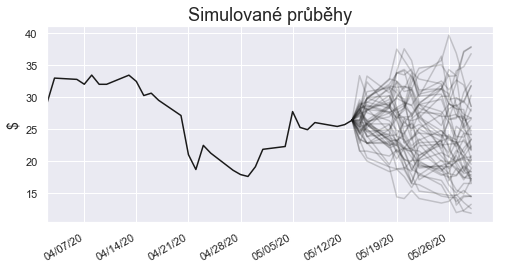

In [24]:
import matplotlib.dates as mdates

week = mdates.WeekdayLocator()
fmt = mdates.DateFormatter('%D')

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.set_title("Simulované průběhy", fontsize=18)
ax.plot(contract.iloc[-30:,0],color="k")
for path in paths[:50]:
    ax.plot(all_days, path, color="k", alpha=0.2)
ax.set_ylabel("$",fontsize=14)
ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(fmt)
ax.set_xlim(contract.index[-30], all_days[-1]+BDay())
fig.autofmt_xdate()
plt.show()
fig.savefig('sim_asian2.pdf', format='pdf', bbox_inches='tight')

Příprava parametrů pro vzorec, dostupný v CD u knihy The Complete Guide To Option Pricing Formulas

In [25]:
# value for volatility of entrire dataset
sigma = contract.iloc[:,1].std()

time_to_avg = (steps - avg_steps)/252

params = pd.DataFrame(
                        {"Params":[init_price,0, strike,time_to_avg, maturity, avg_steps, 0, discount_rate * 100, (sigma * np.sqrt(252) * 100)]},
                        index=["S","SA","X","t","Maturity","n","m","r","sigma"]
                        )
params

,Params
S,26.410000
SA,0.000000
X,50.000000
t,-0.035714
Maturity,0.047619
n,21.000000
m,0.000000
r,1.000000
sigma,65.912407


### Výpočet konfidenčního intervalu

In [26]:
s = pd.Series(payoffs)

In [27]:
s.std()

2.8296559998230557

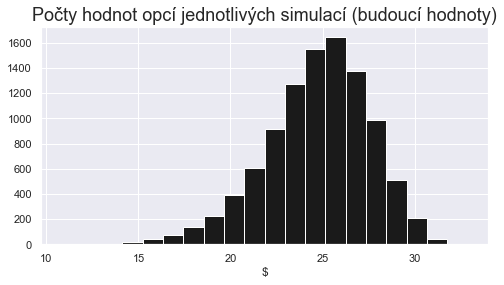

In [28]:
plt.figure(figsize=(8, 4))
plt.title("Počty hodnot opcí jednotlivých simulací (budoucí hodnoty)", fontsize=18)
plt.xlabel("$")
plt.hist(s, bins=20, color="k")
plt.plot()
plt.savefig('sim_asian_payoffs2.pdf', format='pdf', bbox_inches='tight')

In [29]:
se = s.std()/np.sqrt(sim)
se

0.028296559998230556

Mnohem menší standard error oproti druhému výpočtu, kdy byla doba do expirace delší.

Miscellaneous

In [30]:
time_to_avg

-0.03571428571428571

In [31]:
steps - avg_steps

-9